In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, joblib
import lightgbm as lgb
from itertools import combinations
from create_feature import ( reduce_mem_usage )

from sklearn.metrics import mean_absolute_error

In [2]:
def load_csv(csv_file):
    df = pd.read_csv(csv_file)
    df = reduce_mem_usage(df)
    df = df[df['target'].notnull()].reset_index(drop=True)
    df = df.drop(columns=['row_id', 'time_id'])
    df['imbalance_buy_sell_flag'] = df['imbalance_buy_sell_flag'].replace({-1: 0, 1: 1})
    return df

def gen_features(df):

    prices =  ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]

    ## V1 features: row-wise features
    v1_features = {
        "volume": "ask_size + bid_size",
        "mid_price": "(ask_price + bid_price)/2",
        "liquidity_imbalance": "(bid_size-ask_size)/(bid_size+ask_size)",
        "matched_imbalance": "(imbalance_size - matched_size)/(matched_size+imbalance_size)",
        "size_imbalance": "bid_size / ask_size",
        "imbalance_intensity": "imbalance_size / volume",
        "matched_intensity": "matched_size / volume",
        "price_spread": "ask_price - bid_price",
        'market_urgency': 'price_spread * liquidity_imbalance',
        'depth_pressure': '(ask_size - bid_size) * (far_price - near_price)',
        'price_pressure': 'imbalance_size * (ask_price - bid_price)',
        'imbalance_with_flag': 'imbalance_size * imbalance_buy_sell_flag',
        'far_price_near_price_imbalance': '(far_price - near_price) / (far_price + near_price)',
    }

    # include pair-wise price imbalances
    for c in combinations(["reference_price", "ask_price", "bid_price", "wap"], 2):
        v1_features[f"{c[0]}_{c[1]}_imbalance"] = f"({c[0]} - {c[1]}) / ({c[0]} + {c[1]})"

    for k, v in v1_features.items():
        df[k] = df.eval(v)

    # fill nan before calculating rolling stats
    df.fillna(0, inplace=True)

    # time-seires shifts
    roll_window = 5
    gp = df.groupby(['date_id', 'stock_id'])

    row_shifts = [
        gp[prices+sizes].shift(i).add_prefix(f"prev_{i}_") for i in range(1, roll_window+1) 
        ]
    
    df_shifts = pd.concat(row_shifts, axis=1)
    for col in prices+sizes:
        prev_cols = [f"prev_{i}_{col}" for i in range(1, roll_window+1)]
        df_shifts[f"mean_{roll_window}_"+col] = df_shifts[prev_cols].mean(axis=1)
        df_shifts[f"std_{roll_window}_"+col] = df_shifts[prev_cols].std(axis=1)
        df_shifts.drop(columns=prev_cols, inplace=True)

    df_shifts = df_shifts.fillna(0)

    future_wap = gp['wap'].shift(-6).rename('future_wap')
    wap_chg = 1e4 * (future_wap / df['wap'] - 1).rename('wap_chg') 

    df = pd.concat([df, future_wap, wap_chg, df_shifts], axis=1)
    df = df.dropna().reset_index(drop=True)

    # This feature shall be pre-calculated and loaded from an external csv. We don't use it for now.
    # wap_chg_std = df.groupby(['date_id', 'stock_id'])['wap_chg'].std().reset_index().rename(columns={'wap_chg': 'wap_chg_std'})
    # df = df.merge(wap_chg_std, on=['date_id', 'stock_id'], how='left')
    df.replace([np.inf, -np.inf], 0, inplace=True)
    df = reduce_mem_usage(df, verbose=0)

    return df

In [3]:
save_dir = "/home/lishi/projects/Competition/kaggle_2023/data/wap_pred_models"

train_csv = "/home/lishi/projects/Competition/kaggle_2023/data/train.csv"
df_all = load_csv(train_csv)
df_all = gen_features(df_all)

print("Load Data of Shape: ", df_all.shape)
print("Training days: ", df_all['date_id'].nunique())
print("Stocks: ", df_all['stock_id'].nunique())

feature_cols = [x for x in df_all.columns if x not in ['target', 'date_id', 'future_wap', 'wap_chg']]
category_cols = ['stock_id', 'seconds_in_bucket', 'imbalance_buy_sell_flag' ]
target_col = 'wap_chg'

print(len(feature_cols))

Load Data of Shape:  (4666368, 36)
Training days:  481
Stocks:  200
32


In [4]:
def calc_mae(y1, y2):
    return np.nanmean(np.abs(y1-y2))

In [5]:
def plot_stock_prediction(stock_choice, date_choice=[10, 100, 200, 300], n_fold=5, ax_grid=(2, 2)):

    scaler_features = joblib.load(f"{save_dir}/scaler_features_{stock_choice}.pkl")
    scaler_target = joblib.load(f"{save_dir}/scaler_target_{stock_choice}.pkl")

    model_list = [joblib.load(f"{save_dir}/lgbm_{stock_choice}_{i}.pkl") for i in range(n_fold)]

    fig, axes = plt.subplots(*ax_grid, figsize=(12, 8), sharex=True)

    for ax, date_idx in list(zip(axes.flatten(), date_choice)):

        df = df_all[ (df_all['date_id'] == date_idx) & (df_all['stock_id'] == stock_choice) ].copy()

        df_raw = df.copy()

        scale_cols = [x for x in feature_cols if x not in category_cols]
        df[scale_cols] = scaler_features.transform(df[scale_cols])
        df[target_col] = scaler_target.transform(df[[target_col]])

        df['pred_wap_chg'] = np.mean([m.predict(df[feature_cols]) for m in model_list], axis=0)

        pred_wap_chg = scaler_target.inverse_transform(df[['pred_wap_chg']])

        df_raw['pred_wap_chg'] = pred_wap_chg

        df_raw['pred_future_wap'] = df_raw['wap'] * (1 + df_raw['pred_wap_chg'] / 1e4)

        df_raw['future_wap'].replace(0, np.nan, inplace=True)

        mae = calc_mae(df_raw['future_wap'], df_raw['pred_future_wap']) 
        bench = calc_mae(df_raw['future_wap'], df_raw['wap']) 

        sns.lineplot(data=df_raw, x='seconds_in_bucket', y='pred_future_wap', ax=ax, label='predict_wap', color='red', linewidth=2)
        sns.lineplot(data=df_raw, x='seconds_in_bucket', y='future_wap', ax=ax, label='future_wap', color='black', linewidth=2)
        sns.lineplot(data=df_raw, x='seconds_in_bucket', y='wap', ax=ax, label='current_wap', color='gray')
        ax.set_title(f"Date: {date_idx}, MAE: {mae*1e4:.4f}, Bench: {bench*1e4:.4f}")
        ax.grid()

    fig.suptitle(f"Stock: {stock_choice}", fondsize=14)
    fig.tight_layout()
    plt.show()


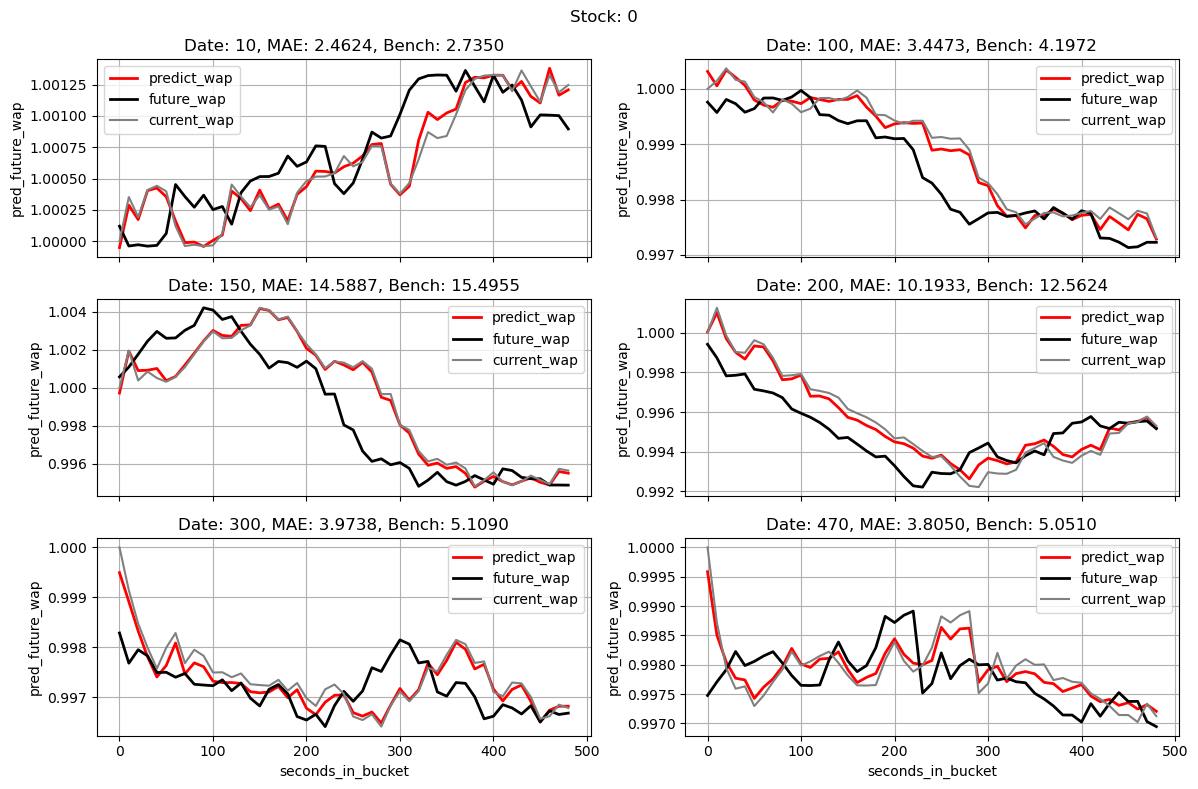

In [6]:
plot_stock_prediction(0, [10, 100, 150, 200, 300, 470], n_fold=1, ax_grid=(3, 2))

In [ ]:
plot_stock_prediction(3, [10, 100, 150, 200, 300, 470], ax_grid=(3, 2))

In [ ]:
plot_stock_prediction(17, [10, 100, 150, 200, 300, 470], ax_grid=(3, 2))

In [ ]:
plot_stock_prediction(12, [10, 100, 150, 200, 300, 470], ax_grid=(3, 2))

In [ ]:
from sklearn.model_selection import train_test_split, KFold

dates_list = df_all['date_id'].unique()

ksplit = KFold(n_splits=5, shuffle=False)
for fold, (x, y) in enumerate(ksplit.split(dates_list)):
    print(x)
    print(y)

In [ ]:
ksplit.get_n_splits(dates_list)